In [ ]:
import os
os.chdir('/content/drive/My Drive/Comp fraud detection')

In [ ]:
import pandas as pd
df1=pd.read_csv('./Data/Xente_Variable_Definitions.csv')

In [ ]:
train_data=pd.read_csv('./Data/training.csv')
test_data=pd.read_csv('./Data/test.csv')

In [ ]:
for i in range(len(df1)):
  print(df1.loc[i,'Column Name'	]+ '      '+ df1.loc[i,'Definition'])

TransactionId      Unique �transaction identifier on platform
BatchId      Unique number assigned to a batch of transactions for processing
AccountId      Unique number identifying the customer on platform
SubscriptionId      Unique number identifying the customer subscription
CustomerId      Unique identifier attached to Account
CurrencyCode      Country currency
CountryCode      Numerical geographical code of country
ProviderId      Source provider of Item �bought.
ProductId      Item name being bought.
ProductCategory      ProductIds are organized into these broader product categories.
ChannelId      Identifies if customer used web,Android, IOS, pay later or checkout.
Amount      Value of the transaction. Positive for debits from customer account and negative for credit into customer account
Value      Absolute value of the amount
TransactionStartTime      Transaction start time
PricingStrategy      Category of Xente's pricing structure for merchants
FraudResult      Fraud status of

In [ ]:
train_data.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15T02:18:49Z,2,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15T02:19:08Z,2,0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15T02:44:21Z,2,0
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15T03:32:55Z,2,0
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15T03:34:21Z,2,0


In [ ]:
print(set(train_data['CurrencyCode'].values))
print(set(train_data['CountryCode'].values))
print((set(train_data['ChannelId'].values)))
print((set(train_data['PricingStrategy'].values)))
print((set(train_data['ProductCategory'].values)))

{'UGX'}
{256}
{'ChannelId_2', 'ChannelId_1', 'ChannelId_3', 'ChannelId_5'}
{0, 1, 2, 4}
{'transport', 'other', 'airtime', 'movies', 'utility_bill', 'tv', 'ticket', 'data_bundles', 'financial_services'}


In [ ]:

train_data.drop(['CurrencyCode','CountryCode'],axis=1, inplace=True)
test_data.drop(['CurrencyCode','CountryCode'],axis=1, inplace=True)

In [ ]:
# number of fraud and non-fraud observations in the dataset
frauds = len(train_data[train_data.FraudResult == 1])
nonfrauds = len(train_data[train_data.FraudResult == 0])

In [ ]:
nonfrauds

95469

In [ ]:
frauds

193

In [ ]:
import numpy as np
list(x for x in set(train_data["Amount"].values) if (not type(x)==np.float64))
#all values are float

[]

In [ ]:
from sklearn.preprocessing import RobustScaler
rob_scaler = RobustScaler()
train_data['scaled_amount'] = rob_scaler.fit_transform(train_data['Amount'].values.reshape(-1,1))
test_data['scaled_amount'] = rob_scaler.transform(test_data['Amount'].values.reshape(-1,1))

In [ ]:

#add scaled amount feature

In [ ]:
set(test_data["AccountId"].values).issubset(set(train_data["AccountId"].values))
#some accounts in train don't exist in test

False

In [ ]:
train_accountID_values=set(train_data["AccountId"].values)
non_exist=0
for x in set(test_data["AccountId"].values):
  if x not in train_accountID_values:
    non_exist+=1
#percentage of new accounts
non_exist/len(set(test_data["AccountId"].values))*100


48.88709024686362

In [ ]:
#clean string features
import re
cols_to_conv=['TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId', 'ProviderId','ProductId',	'ChannelId']
for column in cols_to_conv:
  for i in range(len(train_data)):
    train_data.loc[i,column]=int(re.sub('[a-zA-Z_]','',train_data.loc[i,column]))

cols_to_conv=['TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId', 'ProviderId','ProductId',	'ChannelId']
for column in cols_to_conv:
  for i in range(len(test_data)):
    test_data.loc[i,column]=int(re.sub('[a-zA-Z_]','',test_data.loc[i,column]))

In [ ]:
train_data.to_csv('Data/clean_train.csv', index=False)
test_data.to_csv('Data/clean_test.csv', index=False)

In [4]:
import pandas as pd
clean_test=pd.read_csv("Data/clean_test.csv")
clean_train=pd.read_csv("Data/clean_train.csv")

In [7]:
import datetime
def to_date(char):
  numbers=re.findall(r'\d+', char)
  yy=int(numbers[0])
  mm=int(numbers[1])
  dd=int(numbers[2])
  hh=int(numbers[3])
  mn=int(numbers[4])
  ss=int(numbers[5])
  date=datetime.datetime(yy,mm,dd,hh,mn,ss)
  wd=date.weekday()
  return(yy,mm,dd,hh,mn,ss,wd)
years = [to_date(date)[0] for date in clean_train["TransactionStartTime"]]
months= [to_date(date)[1] for date in clean_train["TransactionStartTime"]]
days = [to_date(date)[2] for date in clean_train["TransactionStartTime"]]
hours = [to_date(date)[3] for date in clean_train["TransactionStartTime"]]
minutes = [to_date(date)[4] for date in clean_train["TransactionStartTime"]]
seconds = [to_date(date)[5] for date in clean_train["TransactionStartTime"]]
weekdays = [to_date(date)[6] for date in clean_train["TransactionStartTime"]]

In [8]:
DT_data=pd.DataFrame(list(zip(years,months,days,hours,minutes,seconds,weekdays,list(clean_train["FraudResult"]))),
                     columns=["year","month","day","hour","minute","second","weekday","FraudResult"])
DT_data.head()

,year,month,day,hour,minute,second,weekday,FraudResult
0,2018,11,15,2,18,49,3,0
1,2018,11,15,2,19,8,3,0
2,2018,11,15,2,44,21,3,0
3,2018,11,15,3,32,55,3,0
4,2018,11,15,3,34,21,3,0


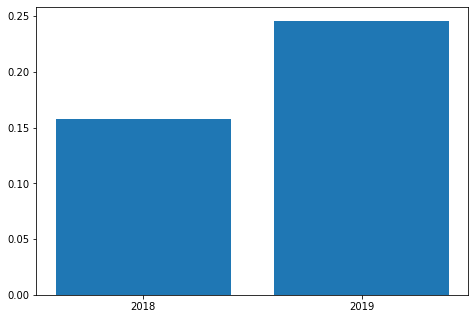

In [9]:
#percentage of frauds/year
import matplotlib.pyplot as plt
year_data=pd.DataFrame()
for year in set(years):
  n_frauds=len(DT_data[(DT_data["year"]==year) & (DT_data["FraudResult"]==1)])
  n=len(DT_data[DT_data["year"]==year ])
  year_data.loc[year, "%frauds/year"]=n_frauds/n*100


fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
XX = list(year_data.index.astype('str'))
YY = list(year_data["%frauds/year"].values)
ax.bar(XX,YY)
plt.show()

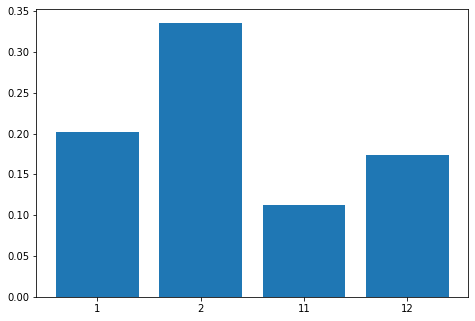

In [10]:
#percentage of frauds/month
month_data=pd.DataFrame()
for month in set(months):
  n_frauds=len(DT_data[(DT_data["month"]==month) & (DT_data["FraudResult"]==1)])
  n=len(DT_data[DT_data["month"]==month ])
  month_data.loc[month, "%frauds/month"]=n_frauds/n*100


fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
XX = list(month_data.index.astype('str'))
YY = list(month_data["%frauds/month"].values)
ax.bar(XX,YY)
plt.show()

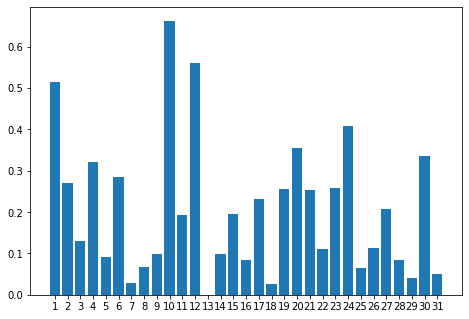

In [11]:
#percentage of frauds/day of month
day_data=pd.DataFrame()
for day in set(days):
  n_frauds=len(DT_data[(DT_data["day"]==day) & (DT_data["FraudResult"]==1)])
  n=len(DT_data[DT_data["day"]==day ])
  day_data.loc[day, "%frauds/day"]=n_frauds/n*100


fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
XX = list(day_data.index.astype('str'))
YY = list(day_data["%frauds/day"].values)
ax.bar(XX,YY)
plt.show()

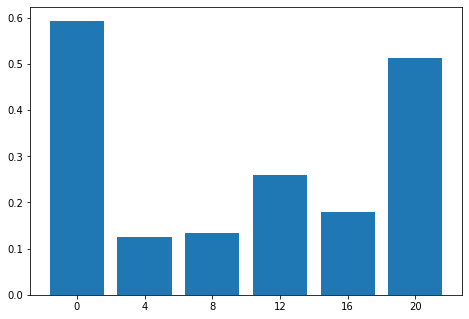

In [12]:
#percentage of frauds/hours inteval
#1st interval 00:00 to 04:00
#lastinterval 20:00 to 00:00
hours_subsets=[0,4,8,12,16,20]
hour_data=pd.DataFrame()
for h in hours_subsets:
  sub=[h, h + 1, h+2, h+3]
  n_frauds=0
  n=0
  for hour in sub:
    n_frauds+=len(DT_data[(DT_data["hour"]==hour) & (DT_data["FraudResult"]==1)])
    n+=len(DT_data[DT_data["hour"]==hour ])
  hour_data.loc[h, "%frauds/hour"]=n_frauds/n*100


fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
XX = list(hour_data.index.astype('str'))
YY = list(hour_data["%frauds/hour"].values)
ax.bar(XX,YY)
plt.show()

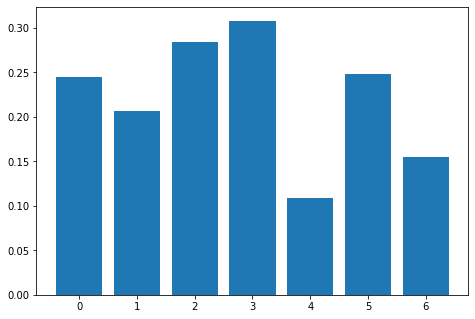

In [13]:
#percentage of frauds/weekkday inteval
wd_data=pd.DataFrame()
for	weekday in set(weekdays):
  n_frauds=len(DT_data[(DT_data["weekday"]==	weekday) & (DT_data["FraudResult"]==1)])
  n=len(DT_data[DT_data["weekday"]==weekday ])
  day_data.loc[	weekday, "%frauds/weekday"]=n_frauds/n*100


fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
XX = list(day_data.index)
YY = list(day_data["%frauds/weekday"].values)
ax.bar(XX,YY)
plt.show()

In [14]:
#The significant features are related to hours: the last interval is the most suceptible to be contain the highest fraud %
clean_train["dang_hour"]=((DT_data["hour"]==0) |(DT_data["hour"]==20) ).astype(int)
clean_test["dang_hour"]=((DT_data["hour"]==0) |(DT_data["hour"]==20) ).astype(int)


In [16]:
#big amounts tend to be fraudent
threshhold=5*100000
clean_train.loc[clean_train["Amount"]>=5*100000, 'Big Amount']=1
clean_train.loc[clean_train["Amount"]<5*100000, 'Big Amount']=0

clean_test.loc[clean_test["Amount"]>=5*100000, 'Big Amount']=1
clean_test.loc[clean_test["Amount"]<5*100000, 'Big Amount']=0

In [41]:
channels_data=pd.DataFrame()
for channel in set(clean_train["ChannelId"].values):
  n_frauds=len(clean_train[(clean_train["ChannelId"]==channel) & ((clean_train["FraudResult"]).astype(int)==1)])
  channels_data.loc[channel,"%frauds/channel"]=100*n_frauds/len(clean_train[clean_train["ChannelId"]==channel])
channels_data.head(10)

,%frauds/channel
1,0.743494
2,0.013462
3,0.323176
5,0.000000


In [18]:
#suspecious channels 
clean_train.loc[(clean_train['ChannelId']==3) | clean_train['ChannelId']==1 , 'Channel1-3']  = 2
clean_train.loc[(clean_train['ChannelId']==2) , 'Channel1-3']  = 1
clean_train.loc[(clean_train['ChannelId']==5) , 'Channel1-3']  = 0
clean_test.loc[(clean_test['ChannelId']==3) | clean_test['ChannelId']==1 , 'Channel1-3']  = 2
clean_test.loc[(clean_test['ChannelId']==2) , 'Channel1-3']  = 1
clean_test.loc[(clean_test['ChannelId']==5) , 'Channel1-3']  = 0

In [29]:
Category_data=pd.DataFrame()
for Category in set(clean_train["ProductCategory"]):
  n_frauds=len(clean_train[(clean_train["ProductCategory"]==Category) & ((clean_train["FraudResult"]).astype(int)==1)])
  Category_data.loc[Category,"%frauds/prod"]=n_frauds/len(clean_train[clean_train["ProductCategory"]==Category])
Category_data

,%frauds/prod
tv,0.000000
movies,0.000000
data_bundles,0.000000
transport,0.080000
utility_bill,0.006250
financial_services,0.003546
ticket,0.000000
other,0.000000
airtime,0.000400


In [31]:
#dangerous product categories
clean_train.loc[clean_train['ProductCategory']=='transport' , 'Product_type']  = 3
clean_train.loc[clean_train['ProductCategory']=='utility_bill' , 'Product_type']  = 2
clean_train.loc[clean_train['ProductCategory']=='financial_services' , 'Product_type']  = 2
clean_train.loc[clean_train['ProductCategory']=='airtime' , 'Product_type']  = 1
for term in ['movies', 'tv', 'other','data_bundles','ticket']:
  clean_train.loc[clean_train['ProductCategory']==term , 'Product_type']  = 0

In [32]:
clean_test.loc[clean_test['ProductCategory']=='transport' , 'Product_type']  = 3
clean_test.loc[clean_test['ProductCategory']=='utility_bill' , 'Product_type']  = 2
clean_test.loc[clean_test['ProductCategory']=='financial_services' , 'Product_type']  = 2
clean_test.loc[clean_test['ProductCategory']=='airtime' , 'Product_type']  = 1
for term in ['movies', 'tv', 'other','data_bundles','ticket']:
  clean_test.loc[clean_test['ProductCategory']==term , 'Product_type']  = 0

In [33]:
products_data=pd.DataFrame()
for product in set(clean_train["ProductId"]):
  n_frauds=len(clean_train[(clean_train["ProductId"]==product) & ((clean_train["FraudResult"]).astype(int)==1)])
  products_data.loc[product,"%frauds/prod"]=100*n_frauds/len(clean_train[clean_train["ProductId"]==product])

In [34]:
products_data.head(15)

,%frauds/prod
1,0.000000
2,0.000000
3,0.049293
4,0.000000
5,8.000000
6,0.003064
7,0.000000
8,0.000000
9,17.647059
10,0.039002


In [35]:
#dangerous products
clean_train.loc[(clean_train['ProductId']==9) |  (clean_train['ProductId']==5), 'dang_product']  = 2
clean_train.loc[(clean_train['ProductId']==13) |  (clean_train['ProductId']==15), 'dang_product']  = 1
clean_train.loc[(clean_train['ProductId']!=9) |  (clean_train['ProductId']!=5) | 
                (clean_train['ProductId']!=13) | (clean_train['ProductId']!=15) , 'dang_product']  = 0
clean_test.loc[(clean_test['ProductId']==9) |  (clean_test['ProductId']==5), 'dang_product']  = 2
clean_test.loc[(clean_test['ProductId']==13) |  (clean_test['ProductId']==15), 'dang_product']  = 1
clean_test.loc[(clean_test['ProductId']!=9) |  (clean_test['ProductId']!=5) | 
                (clean_test['ProductId']!=13) | (clean_test['ProductId']!=15) , 'dang_product']  = 0

In [37]:
strategies_data=pd.DataFrame()
for strategy in set(clean_train["PricingStrategy"]):
  n_frauds=len(clean_train[(clean_train["PricingStrategy"]==strategy) & ((clean_train["FraudResult"]).astype(int)==1)])
  strategies_data.loc[strategy,"%frauds/strategy"]=n_frauds/len(clean_train[clean_train["PricingStrategy"]==strategy])
strategies_data

,%frauds/strategy
0,0.093506
1,0.003749
2,0.001741
4,0.000811


In [38]:
#dangerous pricing strategies
clean_train.loc[clean_train['PricingStrategy']==0, 'dang_strategy']  = 1
clean_train.loc[clean_train['PricingStrategy']!=0, 'dang_strategy' ]  = 0
clean_test.loc[clean_test['PricingStrategy']==0, 'dang_strategy']  = 1
clean_test.loc[clean_test['PricingStrategy']!=0, 'dang_strategy' ]  = 0

In [39]:
providers_data=pd.DataFrame()
for provider in set(clean_train["ProviderId"]):
  n_frauds=len(clean_train[(clean_train["ProviderId"]==provider) & ((clean_train["FraudResult"]).astype(int)==1)])
  providers_data.loc[provider,"%frauds/provider"]=n_frauds/len(clean_train[clean_train["ProviderId"]==provider])
providers_data

,%frauds/provider
1,0.010101
2,0.000000
3,0.020752
4,0.000131
5,0.004401
6,0.000088


In [40]:
#dangerous providers
clean_train.loc[(clean_train['ProviderId']==3) |(clean_train['ProviderId']==1) , 'dang_provider']  = 2
clean_train.loc[(clean_train['ProviderId']==4) |(clean_train['ProviderId']==5) |(clean_train['ProviderId']==6) , 'dang_provider']  = 1
clean_train.loc[(clean_train['ProviderId']==2) , 'dang_provider']  = 0
clean_test.loc[(clean_test['ProviderId']==3) |(clean_test['ProviderId']==1), 'dang_provider']  = 2
clean_test.loc[(clean_test['ProviderId']==4) |(clean_test['ProviderId']==5)| (clean_test['ProviderId']==6), 'dang_provider']  = 1
clean_test.loc[(clean_test['ProviderId']==2) , 'dang_provider']  = 0

In [42]:
clean_train['scaled_value']=abs(clean_train['scaled_amount'])
clean_test['scaled_value']=abs(clean_test['scaled_amount'])

In [46]:
clean_train.droplean_train.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult,scaled_amount,Big Amount,Channel3,Product_type,Channel1-3,dang_hour,dang_product,dang_strategy,dang_provider,scaled_value
0,76871,36123,3957,887,4406,6,10,airtime,3,1000.0,1000,2018-11-15T02:18:49Z,2,0,0.000000,0.0,1.0,1.0,2.0,0,0.0,0.0,1.0,0.000000
1,73770,15642,4841,3829,4406,4,6,financial_services,2,-20.0,20,2018-11-15T02:19:08Z,2,0,-0.357895,0.0,0.0,2.0,1.0,0,0.0,0.0,1.0,0.357895
2,26203,53941,4229,222,4683,6,1,airtime,3,500.0,500,2018-11-15T02:44:21Z,2,0,-0.175439,0.0,1.0,1.0,2.0,0,0.0,0.0,1.0,0.175439
3,380,102363,648,2185,988,1,21,utility_bill,3,20000.0,21800,2018-11-15T03:32:55Z,2,0,6.666667,0.0,1.0,2.0,2.0,0,0.0,0.0,2.0,6.666667
4,28195,38780,4841,3829,988,4,6,financial_services,2,-644.0,644,2018-11-15T03:34:21Z,2,0,-0.576842,0.0,0.0,2.0,1.0,0,0.0,0.0,1.0,0.576842


In [47]:
clean_train['Value+']=(clean_train['Amount']>0).astype('int32')
clean_test['Value+']=(clean_test['Amount']>0).astype('int32')

In [48]:
clean_train["TransactionId"]=clean_train["TransactionId"].astype(str)
clean_test["TransactionId"]=clean_test["TransactionId"].astype(str)
clean_train["BatchId"]=clean_train["BatchId"].astype(str)
clean_test["BatchId"]=clean_test["BatchId"].astype(str)
clean_train["AccountId"]=clean_train["AccountId"].astype(str)
clean_test["AccountId"]=clean_test["AccountId"].astype(str)
clean_train["SubscriptionId"]=clean_train["SubscriptionId"].astype(str)
clean_test["SubscriptionId"]=clean_test["SubscriptionId"].astype(str)
clean_train["CustomerId"]=clean_train["CustomerId"].astype(str)
clean_test["CustomerId"]=clean_test["CustomerId"].astype(str)
clean_train["dang_product"]=clean_train["dang_product"].astype(int)
clean_test["dang_product"]=clean_test["dang_product"].astype(int)
clean_train["Product_type"]=clean_train["Product_type"].astype(int)
clean_test["Product_type"]=clean_test["Product_type"].astype(int)
clean_train["Channel1-3"]=clean_train["Channel1-3"].astype(int)
clean_test["Channel1-3"]=clean_test["Channel1-3"].astype(int)
clean_train["Big Amount"]=clean_train["Big Amount"].astype(int)
clean_test["Big Amount"]=clean_test["Big Amount"].astype(int)
clean_train["scaled_value"]=clean_train["scaled_value"].astype(int)
clean_test["scaled_value"]=clean_test["scaled_value"].astype(int)
clean_train["dang_provider"]=clean_train["dang_provider"].astype(int)
clean_test["dang_provider"]=clean_test["dang_provider"].astype(int)
clean_train["ProductId"]=clean_train["ProductId"].astype(str)
clean_test["ProductId"]=clean_test["ProductId"].astype(str)
clean_train["ProviderId"]=clean_train["ProviderId"].astype(str)
clean_test["ProviderId"]=clean_test["ProviderId"].astype(str)
clean_train["dang_strategy"]=clean_train["dang_strategy"].astype(int)
clean_test["dang_strategy"]=clean_test["dang_strategy"].astype(int)

In [52]:
clean_train.columns

Index(['TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId',
       'ProviderId', 'ProductId', 'ProductCategory', 'ChannelId', 'Amount',
       'Value', 'TransactionStartTime', 'PricingStrategy', 'FraudResult',
       'scaled_amount', 'Big Amount', 'Product_type', 'Channel1-3',
       'dang_hour', 'dang_product', 'dang_strategy', 'dang_provider',
       'scaled_value', 'Value+'],
      dtype='object')

In [54]:
#drop unnecessary columns
X_train = clean_train.drop(['TransactionId', 'Amount', 'Value', 'TransactionStartTime', 'PricingStrategy', 'scaled_value','FraudResult'], axis=1)
X_test = clean_test.drop(['TransactionId', 'Amount', 'Value', 'TransactionStartTime', 'scaled_value','PricingStrategy'], axis=1)

In [56]:
X_test.head()

,BatchId,AccountId,SubscriptionId,CustomerId,ProviderId,ProductId,ProductCategory,ChannelId,scaled_amount,Big Amount,Product_type,Channel1-3,dang_hour,dang_product,dang_strategy,dang_provider,Value+
0,35028,2441,4426,2857,5,3,airtime,3,0.000000,0,1,2,0,0,0,1,1
1,45139,3439,2643,3874,5,15,financial_services,3,0.350877,0,2,2,0,0,0,1,1
2,74887,4841,3829,2857,4,6,financial_services,2,-0.368421,0,2,1,0,0,0,1,0
3,11025,2685,4626,3105,5,10,airtime,3,0.701754,0,1,2,0,0,0,1,1
4,29804,4841,3829,3105,4,6,financial_services,2,-0.371930,0,2,1,0,0,0,1,0


In [57]:
y_train=clean_train[["FraudResult"]]

In [58]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95662 entries, 0 to 95661
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   BatchId          95662 non-null  object 
 1   AccountId        95662 non-null  object 
 2   SubscriptionId   95662 non-null  object 
 3   CustomerId       95662 non-null  object 
 4   ProviderId       95662 non-null  object 
 5   ProductId        95662 non-null  object 
 6   ProductCategory  95662 non-null  object 
 7   ChannelId        95662 non-null  int64  
 8   scaled_amount    95662 non-null  float64
 9   Big Amount       95662 non-null  int64  
 10  Product_type     95662 non-null  int64  
 11  Channel1-3       95662 non-null  int64  
 12  dang_hour        95662 non-null  int64  
 13  dang_product     95662 non-null  int64  
 14  dang_strategy    95662 non-null  int64  
 15  dang_provider    95662 non-null  int64  
 16  Value+           95662 non-null  int32  
dtypes: float64(1

In [ ]:
X_train.head()

,BatchId,AccountId,SubscriptionId,CustomerId,ProviderId,ProductId,ProductCategory,scaled_amount,Big Amount,Providers 1-3-5,Product_type,Channel1-3,dang_product,dang_strategy,dang_provider,Value+
0,36123,3957,887,4406,6,10,airtime,0.000000,0,0.0,1,2,0,0,1,1
1,15642,4841,3829,4406,4,6,financial_services,-0.357895,0,0.0,2,1,0,0,1,0
2,53941,4229,222,4683,6,1,airtime,-0.175439,0,0.0,1,2,0,0,1,1
3,102363,648,2185,988,1,21,utility_bill,6.666667,0,1.0,2,2,0,0,2,1
4,38780,4841,3829,988,4,6,financial_services,-0.576842,0,0.0,2,1,0,0,1,0


In [59]:
!pip install catboost
from catboost import CatBoostClassifier
model = CatBoostClassifier(iterations=1500, learning_rate=0.01, l2_leaf_reg=3.5, depth=8, rsm=0.98, 
                           loss_function= 'Logloss', eval_metric='AUC',random_seed=42)

     |████████████████████████████████| 66.2MB 56kB/s 


In [60]:
import numpy as np
categorical_features_indices = np.where(X_train.dtypes == np.object)[0]
model.fit(X_train, y_train,cat_features=categorical_features_indices)

0:	total: 277ms	remaining: 6m 54s
1:	total: 345ms	remaining: 4m 18s
2:	total: 417ms	remaining: 3m 28s
3:	total: 543ms	remaining: 3m 23s
4:	total: 718ms	remaining: 3m 34s
5:	total: 954ms	remaining: 3m 57s
6:	total: 1.04s	remaining: 3m 41s
7:	total: 1.21s	remaining: 3m 45s
8:	total: 1.33s	remaining: 3m 39s
9:	total: 1.53s	remaining: 3m 48s
10:	total: 1.61s	remaining: 3m 37s
11:	total: 1.74s	remaining: 3m 35s
12:	total: 1.84s	remaining: 3m 30s
13:	total: 1.95s	remaining: 3m 27s
14:	total: 2.13s	remaining: 3m 30s
15:	total: 2.28s	remaining: 3m 31s
16:	total: 2.4s	remaining: 3m 29s
17:	total: 2.45s	remaining: 3m 21s
18:	total: 2.56s	remaining: 3m 19s
19:	total: 2.73s	remaining: 3m 22s
20:	total: 2.94s	remaining: 3m 27s
21:	total: 3.06s	remaining: 3m 25s
22:	total: 3.27s	remaining: 3m 30s
23:	total: 3.44s	remaining: 3m 31s
24:	total: 3.53s	remaining: 3m 28s
25:	total: 3.76s	remaining: 3m 33s
26:	total: 3.82s	remaining: 3m 28s
27:	total: 4.03s	remaining: 3m 31s
28:	total: 4.18s	remaining: 3m 

In [61]:
pred = model.predict(X_test)
threshold = 0.5
pred  = (pred >=threshold)*1

In [65]:
#train accuracy
y_train_pred=model.predict(X_train)
(y_train_pred==y_train["FraudResult"]).astype('int32').sum()/len(X_train)

0.9998327444544333

In [ ]:
#Test data is private